<a href="https://colab.research.google.com/github/haricharanvihari/extensive_viz/blob/master/S8_DNN/S8_EVA4S8F10_modular_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

### Adding below module to check if CUDA is available 

In [0]:
class Img_data(object):

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

  def __init__(self):
    super(Img_data, self).__init__()

  def load(self):
   transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
   
   SEED = 1

   # CUDA?
   cuda = torch.cuda.is_available()
   print("CUDA Available?", cuda)

   # For reproducibility
   torch.manual_seed(SEED)

   if cuda:
     torch.cuda.manual_seed(SEED)

   # dataloader arguments - something you'll fetch these from cmdprmt
   dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

   trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

   testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

   self.trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
   self.testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

# Loading data and transforming it
img_data = Img_data()
img_data.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



Let us show some of the training images, for fun.



plane   dog  deer  deer


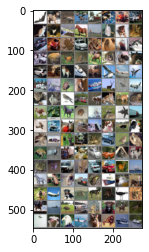

plane   dog  deer  deer


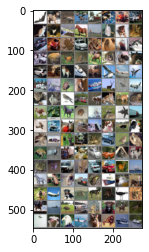

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(img_data.trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % img_data.classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 

        # Depthwise Separable Convolution
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 

        # TRANSITION BLOCK 1
        self.pool2 = nn.MaxPool2d(2, 2) 

        # Dilated Convolution
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
            # nn.ReLU()
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]             576
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
from tqdm import tqdm
import torch.optim as optim

class Data_mod(object):
  def __init__(self):
    super(Data_mod, self).__init__()
    self.train_losses = []
    self.train_acc = []
    self.EPOCHS = 20

  def train(self, model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()

      # Predict
      y_pred = model(data)

      L1 = 0
      # Calculate loss
      loss = F.nll_loss(y_pred, target)
      if L1 > 0:
        l1_crit = nn.L1Loss(size_average = False).to(device)
        l1_loss = 0
        for param in model.parameters():
          zero_vector = torch.rand_like(param) * 0
          l1_loss += l1_crit(param, zero_vector)
        factor = 0.0005
        loss += factor * l1_loss
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)

  def test(self, model, device, test_loader):
      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
  def run_model(self):
    net_model = Net()

    model =  net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    misclassified = []
    for epoch in range(self.EPOCHS):
        print("EPOCH:", epoch + 1)
        self.train(model, device, img_data.trainloader, optimizer, epoch)
        self.test(model, device, img_data.testloader)

In [0]:
# Training dataset and Testing
Datamod = Data_mod()
Datamod.run_model()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.2976831197738647 Batch_id=390 Accuracy=47.84: 100%|██████████| 391/391 [00:28<00:00, 13.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0941, Accuracy: 6146/10000 (61.46%)

EPOCH: 2


Loss=0.7005246877670288 Batch_id=390 Accuracy=65.12: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9686, Accuracy: 6568/10000 (65.68%)

EPOCH: 3


Loss=0.8757087588310242 Batch_id=390 Accuracy=70.60: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7967, Accuracy: 7219/10000 (72.19%)

EPOCH: 4


Loss=0.7934571504592896 Batch_id=390 Accuracy=73.95: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7491, Accuracy: 7379/10000 (73.79%)

EPOCH: 5


Loss=0.7305928468704224 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6923, Accuracy: 7635/10000 (76.35%)

EPOCH: 6


Loss=0.4704747796058655 Batch_id=390 Accuracy=77.33: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6465, Accuracy: 7763/10000 (77.63%)

EPOCH: 7


Loss=0.36640796065330505 Batch_id=390 Accuracy=78.42: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6245, Accuracy: 7839/10000 (78.39%)

EPOCH: 8


Loss=0.6039480566978455 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7173, Accuracy: 7557/10000 (75.57%)

EPOCH: 9


Loss=0.43580907583236694 Batch_id=390 Accuracy=80.30: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6451, Accuracy: 7795/10000 (77.95%)

EPOCH: 10


Loss=0.5531834363937378 Batch_id=390 Accuracy=80.90: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6019, Accuracy: 7921/10000 (79.21%)

EPOCH: 11


Loss=0.5409365296363831 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5853, Accuracy: 7956/10000 (79.56%)

EPOCH: 12


Loss=0.523553729057312 Batch_id=390 Accuracy=81.84: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6002, Accuracy: 7939/10000 (79.39%)

EPOCH: 13


Loss=0.6475805044174194 Batch_id=390 Accuracy=82.67: 100%|██████████| 391/391 [00:27<00:00, 13.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6055, Accuracy: 7903/10000 (79.03%)

EPOCH: 14


Loss=0.3654896318912506 Batch_id=390 Accuracy=82.97: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5463, Accuracy: 8133/10000 (81.33%)

EPOCH: 15


Loss=0.30685216188430786 Batch_id=390 Accuracy=83.07: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5495, Accuracy: 8103/10000 (81.03%)

EPOCH: 16


Loss=0.5161536335945129 Batch_id=390 Accuracy=83.47: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5453, Accuracy: 8175/10000 (81.75%)

EPOCH: 17


Loss=0.6199158430099487 Batch_id=390 Accuracy=83.80: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5133, Accuracy: 8239/10000 (82.39%)

EPOCH: 18


Loss=0.43980589509010315 Batch_id=390 Accuracy=84.08: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5364, Accuracy: 8168/10000 (81.68%)

EPOCH: 19


Loss=0.3586267828941345 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5289, Accuracy: 8205/10000 (82.05%)

EPOCH: 20


Loss=0.3874901533126831 Batch_id=390 Accuracy=84.58: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]



Test set: Average loss: 0.5263, Accuracy: 8249/10000 (82.49%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.3052377700805664 Batch_id=390 Accuracy=47.97: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1037, Accuracy: 6144/10000 (61.44%)

EPOCH: 2


Loss=0.7320210337638855 Batch_id=390 Accuracy=65.08: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0013, Accuracy: 6449/10000 (64.49%)

EPOCH: 3


Loss=0.882132351398468 Batch_id=390 Accuracy=70.63: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8074, Accuracy: 7190/10000 (71.90%)

EPOCH: 4


Loss=0.734429657459259 Batch_id=390 Accuracy=74.10: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7242, Accuracy: 7484/10000 (74.84%)

EPOCH: 5


Loss=0.7219886779785156 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7170, Accuracy: 7517/10000 (75.17%)

EPOCH: 6


Loss=0.5136688947677612 Batch_id=390 Accuracy=77.54: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6429, Accuracy: 7773/10000 (77.73%)

EPOCH: 7


Loss=0.37390613555908203 Batch_id=390 Accuracy=78.31: 100%|██████████| 391/391 [00:28<00:00, 13.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5981, Accuracy: 7920/10000 (79.20%)

EPOCH: 8


Loss=0.596073567867279 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6540, Accuracy: 7753/10000 (77.53%)

EPOCH: 9


Loss=0.41536325216293335 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6798, Accuracy: 7620/10000 (76.20%)

EPOCH: 10


Loss=0.4804072380065918 Batch_id=390 Accuracy=80.87: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6085, Accuracy: 7879/10000 (78.79%)

EPOCH: 11


Loss=0.5671306848526001 Batch_id=390 Accuracy=81.52: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5677, Accuracy: 8016/10000 (80.16%)

EPOCH: 12


Loss=0.49316564202308655 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5909, Accuracy: 7996/10000 (79.96%)

EPOCH: 13


Loss=0.6887737512588501 Batch_id=390 Accuracy=82.68: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5916, Accuracy: 7985/10000 (79.85%)

EPOCH: 14


Loss=0.3657691776752472 Batch_id=390 Accuracy=82.95: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5382, Accuracy: 8149/10000 (81.49%)

EPOCH: 15


Loss=0.23546886444091797 Batch_id=390 Accuracy=83.22: 100%|██████████| 391/391 [00:28<00:00, 13.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5462, Accuracy: 8119/10000 (81.19%)

EPOCH: 16


Loss=0.4598937928676605 Batch_id=390 Accuracy=83.69: 100%|██████████| 391/391 [00:27<00:00, 13.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5184, Accuracy: 8220/10000 (82.20%)

EPOCH: 17


Loss=0.5802720785140991 Batch_id=390 Accuracy=84.08: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5078, Accuracy: 8227/10000 (82.27%)

EPOCH: 18


Loss=0.40445476770401 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5157, Accuracy: 8226/10000 (82.26%)

EPOCH: 19


Loss=0.3777925968170166 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [00:27<00:00, 13.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5012, Accuracy: 8271/10000 (82.71%)

EPOCH: 20


Loss=0.34789735078811646 Batch_id=390 Accuracy=84.82: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]



Test set: Average loss: 0.5099, Accuracy: 8258/10000 (82.58%)

